# Detecting Weapons on images

<img src="misc/weapons3.jpg" alt="Analysis of Corona Virus" style="width: 100%; height: 100%"/>

# Data Load and Preparation for Training

In [1]:
#SAS
from swat import CAS
from dlpy.utils import *
from dlpy.applications import *
from dlpy.model import *
from dlpy.images import *
from dlpy.lr_scheduler import *
from dlpy.splitting import two_way_split
from dlpy.metrics import accuracy_score, confusion_matrix, plot_roc, plot_precision_recall, roc_auc_score, f1_score, average_precision_score

#Open Source
import seaborn as sn

In [2]:
s = CAS('localhost', 5570, 'sas', 'Orion123')

In [3]:
image_path = '/data/notebooks/deep_learning_examples/BKA_Weapon_Detection/Weapons/'
data = ImageTable.load_files(conn=s, 
                             path=image_path, 
                             casout=dict(name='data'))

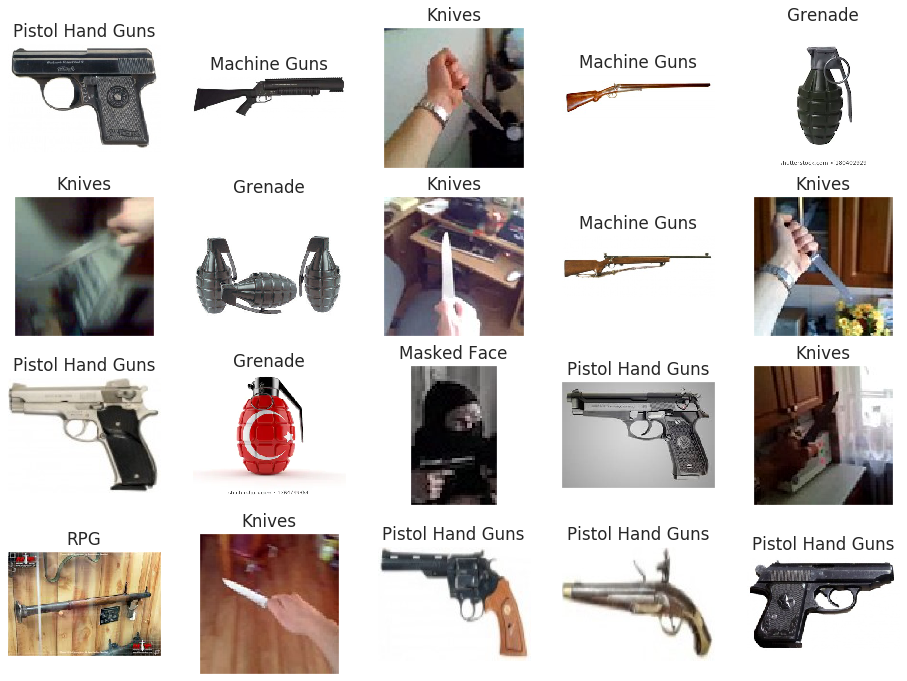

In [130]:
data.show(nimages=20, ncol=5, randomize=True)

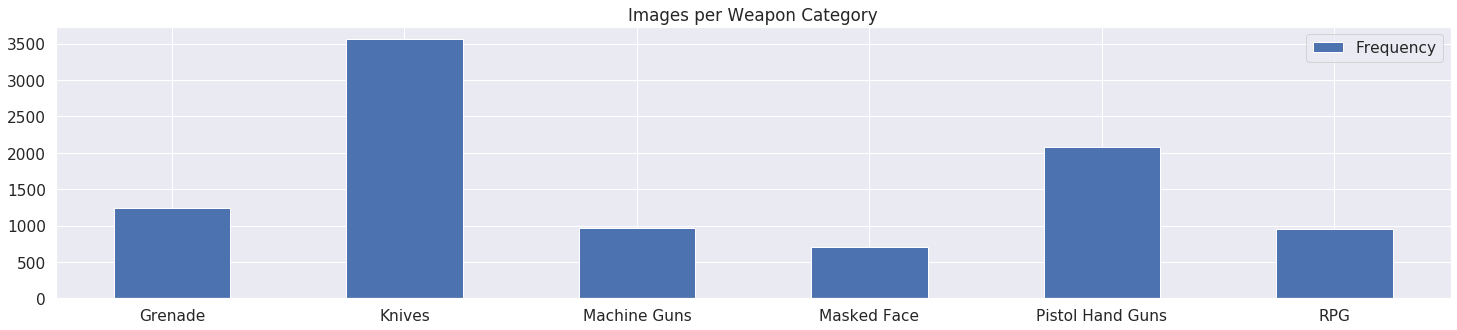

In [135]:
ax = data.label_freq.plot.bar(y='Frequency', rot=0, figsize=(25,5), title='Images per Weapon Category')

In [132]:
data.image_summary

jpg                  9493
minWidth               30
maxWidth             5583
minHeight              38
maxHeight            5674
meanWidth         262.176
meanHeight        207.245
mean1stChannel    133.166
min1stChannel           0
max1stChannel         255
mean2ndChannel    138.839
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    147.724
min3rdChannel           0
max3rdChannel         255
dtype: object

In [4]:
data.shuffle(casout=dict(name='data', replace=True))

[caslib]

 'CASUSER(sas)'

[tableName]

 'DATA'

[casTable]

 CASTable('DATA', caslib='CASUSER(sas)')

+ Elapsed: 0.527s, user: 0.364s, sys: 0.555s, mem: 206mb

In [5]:
# Split Training Data into Train / Test
trainData, validData = two_way_split(data, test_rate=20, seed=12345)

In [ ]:
# Plot class distributions
fig, ax = plt.subplots()
trainData['_label_'].value_counts().plot(ax=ax, kind='bar', rot=45, title='Training Images', figsize=(10,5))
fig, ax = plt.subplots()
validData['_label_'].value_counts().plot(ax=ax, kind='bar', rot=45, title='Test Images', figsize=(10,5))

In [6]:
trainData.resize(width=224, height=224, inplace=True)
validData.resize(width=224, height=224, inplace=True)

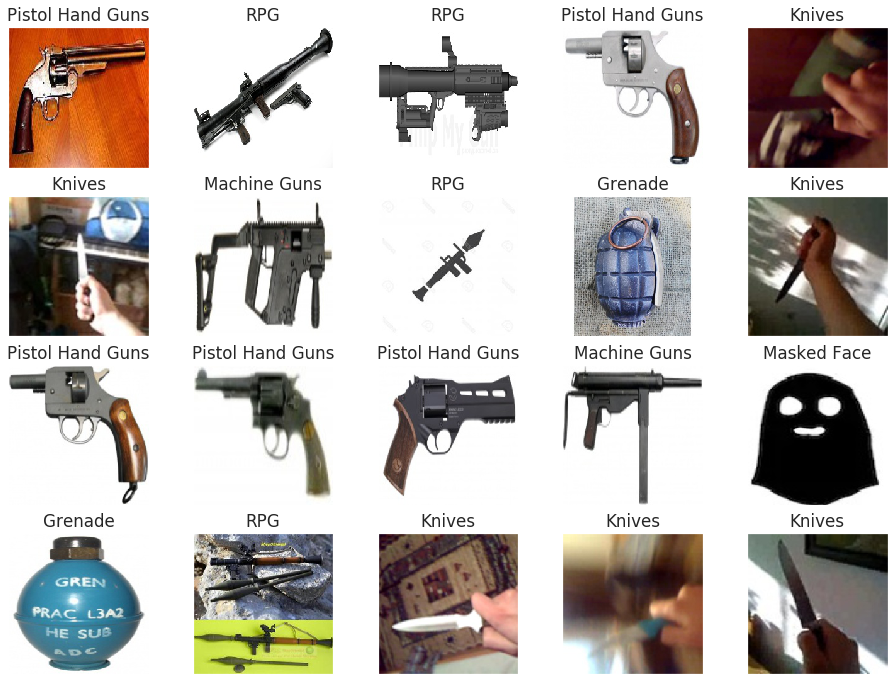

In [136]:
trainData.show(nimages=20, ncol=5, randomize=True)

# Build Image Classification Model (Transfer Learning from pretrained Model)

We will make use of transfer-learning and use a simple pretrained ResNet-50 Model which we'll adjust to our needs.<br>
The model can be downloaded here: https://s3.amazonaws.com/onnx-model-zoo/resnet/resnet50v1/resnet50v1.onnx

In [7]:
import onnx
onnx_model = onnx.load_model('/data/notebooks/deep_learning_examples/models/ONNX/resnet50/resnet50v1.onnx')

In [8]:
model = Model.from_onnx_model(s, 
                               onnx_model,
                               output_model_table='resnet50v1',
                               scale=1./255., 
                               offsets=[0.485, 0.456, 0.406])

NOTE: Successfully written weights file as /data/notebooks/deep_learning_examples/BKA_Weapon_Detection/resnet50v1_weights.onnxmodel.h5
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50v1" according to the model name in the table.
NOTE: Successfully imported ONNX model.


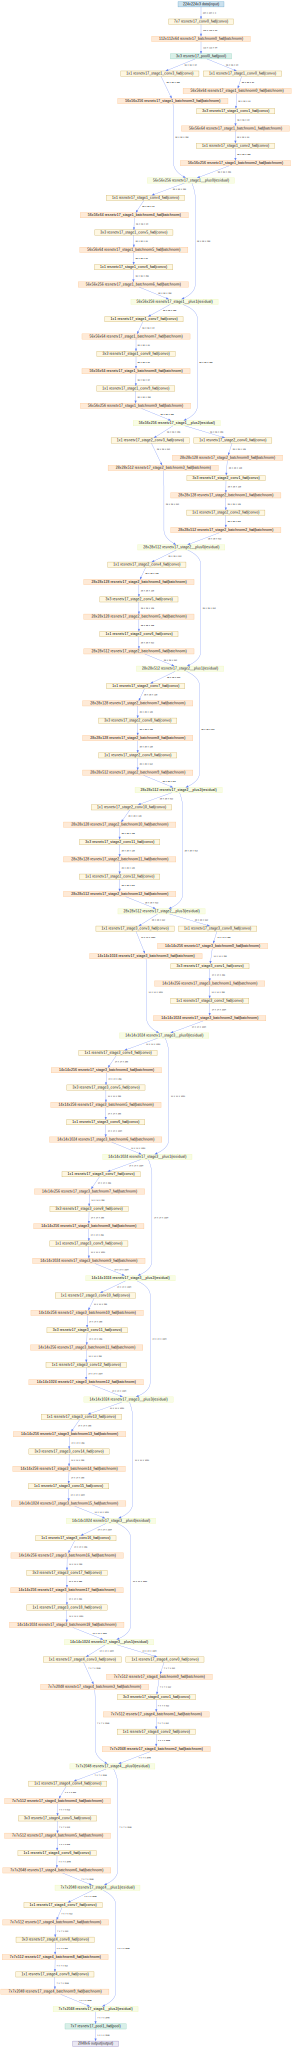

In [133]:
model.plot_network()

In [9]:
# Remove last layer and assign output of 6 classes
model_table = s.CASTable(model.model_table['name'])
model.load_weights(path='/data/notebooks/deep_learning_examples/BKA_Weapon_Detection/resnet50v1_weights.onnxmodel.h5')
s.removelayer(modeltable=model_table, 
              name='resnetv17_dense0_fwd')
s.addlayer(modeltable=model_table, 
           name='output', 
           layer=(dict(type='output', 
                       n=len(trainData.label_freq), 
                       act='softmax')), 
           srcLayers=['resnetv17_pool1_fwd'])
model.model_weights = model.model_weights[model.model_weights['_LayerID_'] < 125]
model = Model.from_table(model_table)

NOTE: no dataspec(s) provided - creating image classification model.
NOTE: Model weights attached successfully!
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50v1" according to the model name in the table.


In [10]:
model.summary

Layer Id                            Layer       Type Kernel Size  \
0       None                             data      input               
1       None              resnetv17_conv0_fwd      convo      (7, 7)   
2       None         resnetv17_batchnorm0_fwd  batchnorm               
3       None              resnetv17_pool0_fwd       pool      (3, 3)   
4       None       resnetv17_stage1_conv3_fwd      convo      (1, 1)   
..       ...                              ...        ...         ...   
121     None       resnetv17_stage4_conv9_fwd      convo      (1, 1)   
122     None  resnetv17_stage4_batchnorm9_fwd  batchnorm               
123     None          resnetv17_stage4__plus2   residual               
124     None              resnetv17_pool1_fwd       pool      (7, 7)   
125     None                           output     output   (2048, 6)   

         Stride Activation     Output Size Number of Parameters  \
0                     None   (224, 224, 3)               (0, 0)   
1    (2.0, 2.0)   Identity  (112, 112, 64)            (9408, 0)   
2                Rectifier  (112, 112, 64)             (0, 128)   
3    (2.0, 2.0)        Max    (56, 56, 64)               (0, 0)   
4    (1.0, 1.0)   Identity   (56, 56, 256)           (16384, 0)   
..          ...        ...             ...                  ...   
121  (1.0, 1.0)   Identity    (7, 7, 2048)      (1048576, 2048)   
122               Identity    (7, 7, 2048)            (0, 4096)   
123              Rectifier    (7, 7, 2048)               (0, 0)   
124  (7.0, 7.0)       Mean    (1, 1, 2048)               (0, 0)   
125                Softmax               6           (12288, 6)   

     FLOPS(forward pass)  
0                      0  
1              118013952  
2                      0  
3                      0  
4               51380224  
..                   ...  
121             51380224  
122                    0  
123                    0  
124                    0  
125                    0  

[126 rows x 9 columns]

In [12]:
# Define training-parameters
lr_scheduler = ReduceLROnPlateau(conn=s, 
                                 cool_down_iters=10, 
                                 gamma=0.1, 
                                 learning_rate=0.01, 
                                 patience=15)
solver = MomentumSolver(momentum=0.9, 
                        lr_scheduler=lr_scheduler, 
                        clip_grad_max=100, 
                        clip_grad_min=-100)
optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=128, 
                      log_level=2, 
                      max_epochs=10, 
                      reg_l2=0.0005,
                      stagnation=10,
                      bn_src_layer_warnings=False)

gpu = Gpu(devices=[0])

dataspecs=[dict(type='image', layer='data', data=['_image_']),
           dict(type='numnom', layer='output', data=['_label_'])]

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


# Start Model Training

In [13]:
# Start Training
model.fit(data=trainData,
          valid_table=validData,
          optimizer=optimizer,
          data_specs=dataspecs, 
          n_threads=1, 
          record_seed=54321,
          force_equal_padding=True, 
          gpu=gpu,
          save_best_weights=True)

NOTE: Training based on existing weights.
NOTE: Using michael-AERO-15-X9: 1 out of 1 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 23539206.
NOTE:  The approximate memory cost is 527.00 MB.
NOTE:  Loading weights cost       0.52 (s).
NOTE:  Initializing each layer cost       3.89 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 128.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      6
NOTE:  Levels for the target variable:
NOTE:  Level      0: Grenade         
NOTE:  Level      1: Knives          
NOTE:  Level      2: Machine Guns    
NOTE:  Level      3: Masked Face     
NOTE:  Level      4: Pistol Hand Guns
NOTE:  Level      5: RPG             
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE: 

[ModelInfo]

                                         Descr                         Value
 0                                  Model Name                    resnet50v1
 1                                  Model Type  Convolutional Neural Network
 2                            Number of Layers                           126
 3                      Number of Input Layers                             1
 4                     Number of Output Layers                             1
 5              Number of Convolutional Layers                            53
 6                    Number of Pooling Layers                             2
 7            Number of Fully Connected Layers                             0
 8        Number of Batch Normalization Layers                            53
 9                   Number of Residual Layers                            16
 10                Number of Weight Parameters                      23467200
 11                  Number of Bias Parameters                         72006
 12           Total Number of Model Parameters                      23539206
 13  Approximate Memory Cost for Training (MB)                           527

[OptIterHistory]

    Epoch  LearningRate      Loss  FitError    L2Norm  ValidLoss  ValidError
 0      1          0.01  0.219024  0.074349  2.951241   0.154405    0.040526
 1      2          0.01  0.051650  0.014974  2.920312   0.058465    0.018947
 2      3          0.01  0.034330  0.010026  2.886896   0.048050    0.019474
 3      4          0.01  0.022900  0.007031  2.853429   0.059498    0.017895
 4      5          0.01  0.016975  0.004818  2.819982   0.058061    0.017368
 5      6          0.01  0.010856  0.002865  2.786673   0.047031    0.013684
 6      7          0.01  0.008379  0.002474  2.753683   0.047651    0.014737
 7      8          0.01  0.010511  0.003125  2.721056   0.050564    0.013684
 8      9          0.01  0.006068  0.001432  2.688771   0.049583    0.012632
 9     10          0.01  0.006288  0.002083  2.656810   0.046006    0.010000

[OutputCasTables]

          casLib                       Name      Rows  Columns  \
 0  CASUSER(sas)  model_best_weights_QC3lvV  23592326        3   
 1  CASUSER(sas)         resnet50v1_weights  23592326        3   
 
                                             casTable  
 0  CASTable('model_best_weights_QC3lvV', caslib='...  
 1  CASTable('resnet50v1_weights', caslib='CASUSER...  

+ Elapsed: 693s, user: 606s, sys: 164s, mem: 566mb

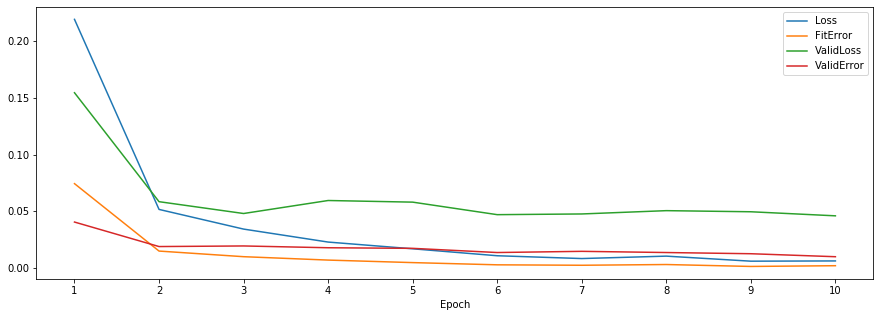

In [14]:
model.plot_training_history(items=['Loss','FitError','ValidLoss','ValidError'], fig_size=(15, 5))

In [123]:
model.evaluate(data=validData, gpu=gpu)

NOTE: Using michael-AERO-15-X9: 1 out of 1 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          1900
 1  Number of Observations Used          1900
 2  Misclassification Error (%)             1
 3                   Loss Error      0.046005

[OutputCasTables]

          casLib              Name  Rows  Columns  \
 0  CASUSER(sas)  Valid_Res_LiPgn1  1900       13   
 
                                             casTable  
 0  CASTable('Valid_Res_LiPgn1', caslib='CASUSER(s...  

+ Elapsed: 8.78s, user: 10.4s, sys: 0.833s, mem: 402mb

In [29]:
print('Accuracy: {} %'.format(accuracy_score(model.valid_res_tbl['_label_'], model.valid_res_tbl['I__label_'])*100))
print('F1 Score: {}'.format(f1_score(model.valid_res_tbl['_label_'], model.valid_res_tbl['I__label_'], pos_label=1)))

Accuracy: 99.0 %
F1 Score: 0.999298245614035


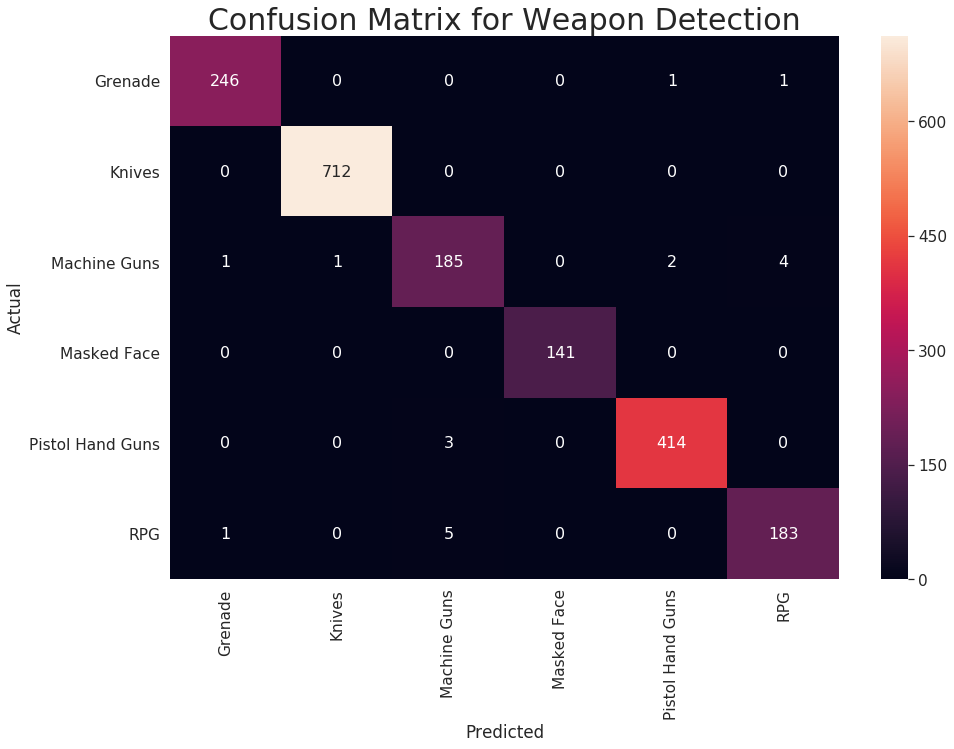

In [37]:
# Get confusion matrix heatmap
cfm_full = confusion_matrix(model.valid_res_tbl['_label_'], model.valid_res_tbl['I__label_'])
cfm_full.index.name = 'Actual'
cfm_full.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix for Weapon Detection', fontsize=30)
sn.set(font_scale=1.4)
sn.heatmap(cfm_full, annot=True, annot_kws={'size':16}, fmt='g')

In [38]:
model.valid_res_tbl.head(10)

Selected Rows from Table VALID_RES_LIPGN1

  _filename_0                                            _image_  _id_  \
0     771.jpg  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  4972   
1     348.jpg  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  2206   
2    2393.jpg  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  5397   
3    1450.jpg  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  6825   
4      50.jpg  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  7608   
5    1679.jpg  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  8495   
6    3028.jpg  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  5140   
7    1434.jpg  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  6555   
8    2351.jpg  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  5924   
9    2347.jpg  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  4034   

            _label_  P__label_Grenade  P__label_Knives  P__label_Machine_Guns  \
0            Knives      5.126844e-10     1.000000e+00           7.764272e-09   
1               RPG      8.376598e-01     7.764101e-04           7.493828e-04   
2            Knives      1.000000e-10     1.000000e+00           1.000000e-10   
3  Pistol Hand Guns      1.612291e-04     2.518449e-05           3.718160e-04   
4  Pistol Hand Guns      2.740007e-07     2.983329e-08           2.625183e-08   
5  Pistol Hand Guns      2.704635e-07     6.271727e-07           1.604667e-06   
6            Knives      1.164217e-07     9.999995e-01           4.201425e-09   
7  Pistol Hand Guns      2.504088e-04     1.037409e-04           4.838771e-01   
8            Knives      1.000000e-10     1.000000e+00           1.000000e-10   
9            Knives      2.649108e-08     9.999988e-01           8.401633e-07   

   P__label_Masked_Face  P__label_Pistol_Hand_Guns  P__label_RPG  \
0          1.590544e-09               1.000000e-10  2.490181e-08   
1          1.448129e-05               1.425239e-05  1.607856e-01   
2          1.000000e-10               1.000000e-10  1.000000e-10   
3          1.112158e-05               9.993811e-01  4.961697e-05   
4          2.021054e-08               9.999982e-01  1.489284e-06   
5          4.811603e-07               9.999969e-01  1.401034e-07   
6          6.628093e-08               1.107000e-07  1.261391e-07   
7          2.262554e-04               5.141947e-01  1.347833e-03   
8          6.247697e-10               1.000000e-10  1.000000e-10   
9          1.242228e-07               2.016222e-08  1.961476e-07   

          I__label_  _DL_PredP_  _DL_PredLevel_  
0            Knives    1.000000             1.0  
1           Grenade    0.837660             0.0  
2            Knives    1.000000             1.0  
3  Pistol Hand Guns    0.999381             4.0  
4  Pistol Hand Guns    0.999998             4.0  
5  Pistol Hand Guns    0.999997             4.0  
6            Knives    1.000000             1.0  
7  Pistol Hand Guns    0.514195             4.0  
8            Knives    1.000000             1.0  
9            Knives    0.999999             1.0

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sas).
NOTE: Table FILTERED_PFFIGZ contains compressed images.
NOTE: Cloud Analytic Services dropped table FILTERED_PFFIGZ from caslib CASUSER(sas).


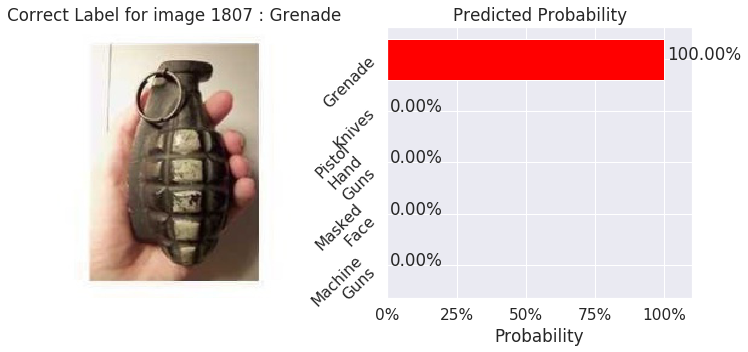

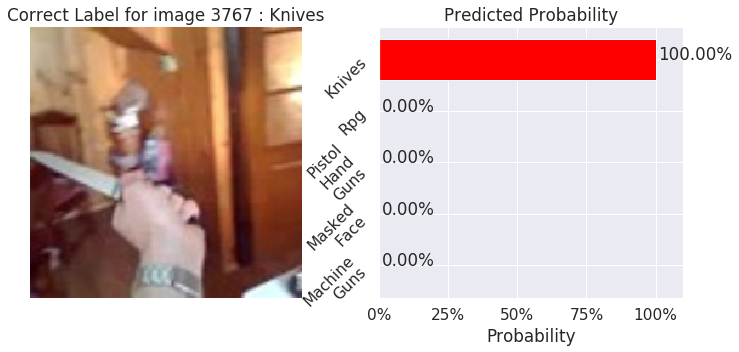

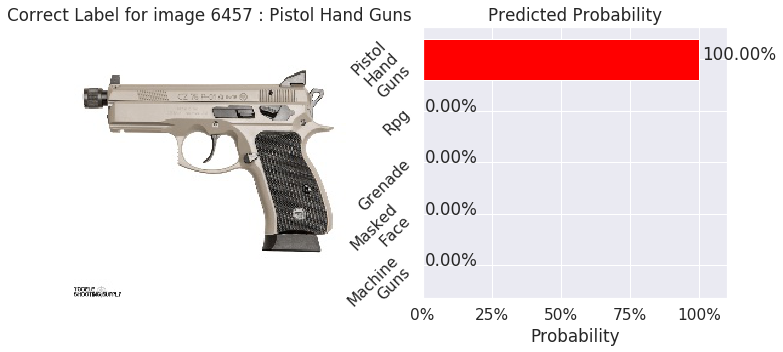

In [26]:
model.plot_evaluate_res(img_type='C', image_id=[3767, 1807, 6457])

Using results from model.predict()
 filtering by filename or _id_ 
NOTE: Cloud Analytic Services dropped table TEMP_ANOTATED from caslib CASUSER(sas).
NOTE: Table FILTERED_ME3MLS contains compressed images.


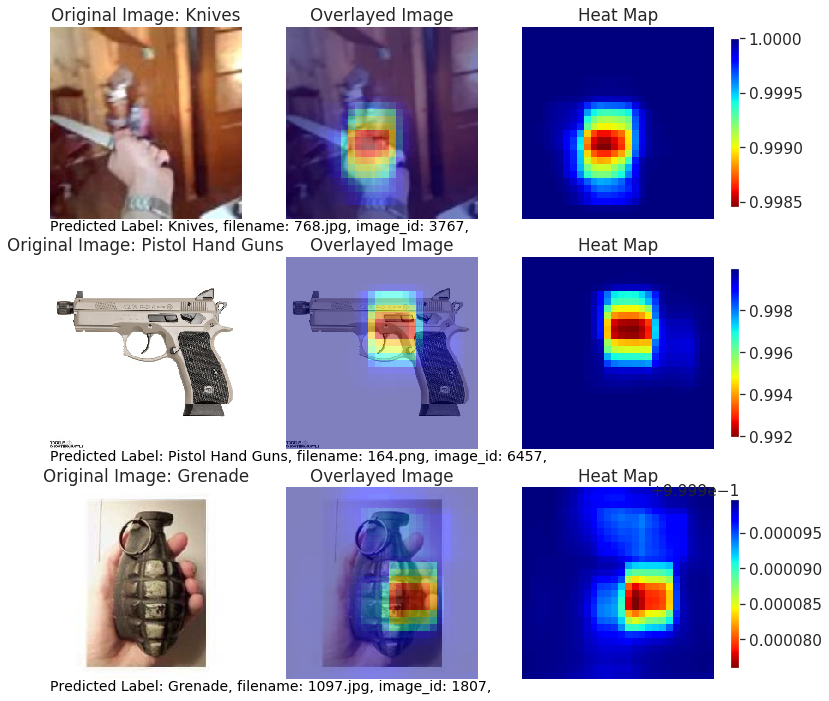

NOTE: Cloud Analytic Services dropped table FILTERED_ME3MLS from caslib CASUSER(sas).


_id_ _filename_0                                            _image_  \
0  3767     768.jpg  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  6457     164.png  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2  1807    1097.jpg  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

            _label_         I__label_  \
0            Knives            Knives   
1  Pistol Hand Guns  Pistol Hand Guns   
2           Grenade           Grenade   

                                            heat_map  P__label_Grenade  \
0  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...      1.000000e-10   
1  [[0.9999992847442627, 0.9999992847442627, 0.99...      1.320811e-07   
2  [[0.9999997615814209, 0.9999997615814209, 0.99...      9.999996e-01   

   P__label_Knives  P__label_Machine_Guns  P__label_Masked_Face  \
0     1.000000e+00           1.000000e-10          1.000000e-10   
1     1.603801e-08           1.928902e-08          5.426697e-08   
2     2.407669e-07           8.257963e-09          2.693830e-08   

   P__label_Pistol_Hand_Guns  P__label_RPG  
0               1.000000e-10  1.000000e-10  
1               9.999993e-01  5.233578e-07  
2               6.448378e-08  4.157311e-09

In [28]:
# Generate Heat Map for test data images 
model.heat_map_analysis(mask_width=56, mask_height=56, step_size=8, image_id=[3767, 1807, 6457])

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sas).


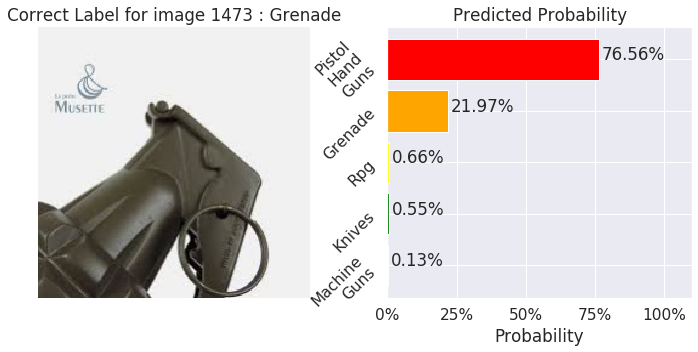

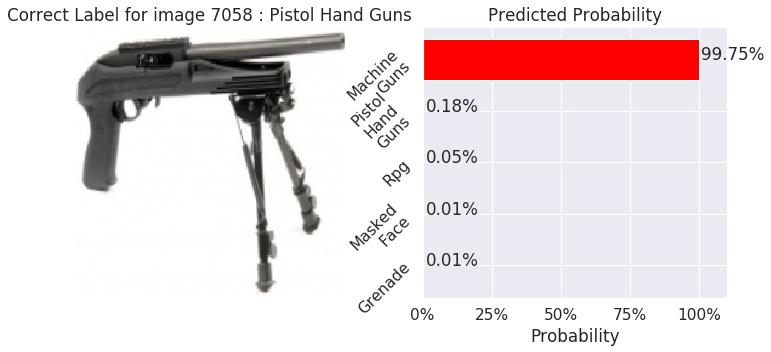

In [27]:
model.plot_evaluate_res(img_type='M', randomize=True, n_images=2)

In [76]:
print('Accuracy: {} %'.format(accuracy_score(model.valid_res_tbl['_label_'], model.valid_res_tbl['I__label_'])*100))
print('F1 Score: {}'.format(f1_score(model.valid_res_tbl['_label_'], model.valid_res_tbl['I__label_'], pos_label=1)))

Accuracy: 99.0 %
F1 Score: 0.999298245614035


# Deploy Models for further Usage

In [ ]:
model.deploy(path='/data/notebooks/deep_learning_examples/BKA_Weapon_Detection/', output_format='astore')

In [ ]:
model.deploy(path='/data/notebooks/deep_learning_examples/BKA_Weapon_Detection/', output_format='castable')

In [ ]:
model.deploy(path='/data/notebooks/deep_learning_examples/BKA_Weapon_Detection/', output_format='onnx')

# Prepare Data for further Visualizations

In [119]:
# Prepare data for visualization
predictions = model.valid_res_tbl
predictions.altertable(columns=[dict(name='_image_', drop=True),
                                dict(name='_id_', drop=True),
                                dict(name='_DL_PredLevel_', drop=True),
                                dict(name='I__label_', rename='Prediction'),
                                dict(name='_DL_PredP_', rename='Probability'),
                                dict(name='_filename_0', rename='Filename')
                               ])
#predictions['image_path'] = image_path + predictions['Filename']
predictions['image_path'] = '/Weapons/' + predictions['_label_'] + '/' + predictions['Filename']
predictions.head()

Selected Rows from Table VALID_RES_LIPGN1

   Filename           _label_  P__label_Grenade  P__label_Knives  \
0   669.jpg               RPG      3.410635e-06     3.352567e-08   
1   961.jpg  Pistol Hand Guns      4.077910e-07     7.040684e-07   
2   729.jpg               RPG      2.213287e-05     7.599338e-05   
3  2477.jpg            Knives      1.000000e-10     1.000000e+00   
4  2191.jpg            Knives      2.543090e-09     9.999998e-01   

   P__label_Machine_Guns  P__label_Masked_Face  P__label_Pistol_Hand_Guns  \
0           2.918619e-06          1.676937e-06               1.281433e-07   
1           5.051707e-06          7.024582e-07               9.999931e-01   
2           1.978283e-05          8.005730e-06               1.891719e-06   
3           1.000000e-10          1.900907e-09               1.000000e-10   
4           3.282976e-09          2.717069e-07               1.000000e-10   

   P__label_RPG        Prediction  Probability  \
0  9.999918e-01               RPG     0.999992   
1  4.911837e-08  Pistol Hand Guns     0.999993   
2  9.998722e-01               RPG     0.999872   
3  1.000000e-10            Knives     1.000000   
4  1.684840e-09            Knives     1.000000   

                          image_path  
0               /Weapons/RPG/669.jpg  
1  /Weapons/Pistol Hand Guns/961.jpg  
2               /Weapons/RPG/729.jpg  
3           /Weapons/Knives/2477.jpg  
4           /Weapons/Knives/2191.jpg

In [120]:
predictions.to_csv('weapon_detection.csv')